# Generative Adversarial Network

Neste notebook, vamos construir uma Rede Neural Generativa (GAN) treinada no dataset MNIST. A partir disso, seremos capazes de gerar novos dígitos escritos à mão. 


GANs foram [reportadas](https://arxiv.org/abs/1406.2661) em 2014 no laboratório  de Yoshua Bengio por Ian Goodfellow. Desde então, as GANs ganharam muita popularidade. Aqui estão alguns exemplos: 

* [Pix2Pix](https://affinelayer.com/pixsrv/)
* [CycleGAN & Pix2Pix in PyTorch, Jun-Yan Zhu](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)
* [A list of generative models](https://github.com/wiseodd/generative-models)

A ideia por trás das GANs é que você possui duas redes, uma *generator* $G$ e uma *discriminator* $D$, uma competindo contra a outra. A generator cria dados "fake" e passa para a discriminator. A discriminator também vê dados reais e tenta predizer se o dado recebido é real ou fake. 

> * A generator é treinada para enganar a discriminator. Tem como objetivo produzir dados que pareçam reais _o máximo possível_.
* A discriminator é um classificador que é treinado para descobrir qual dado é real e qual é fake.

O que acaba acontecendo é o que a generator aprende a produzir dados que são indistinguíveis de dados reais para a discriminator.

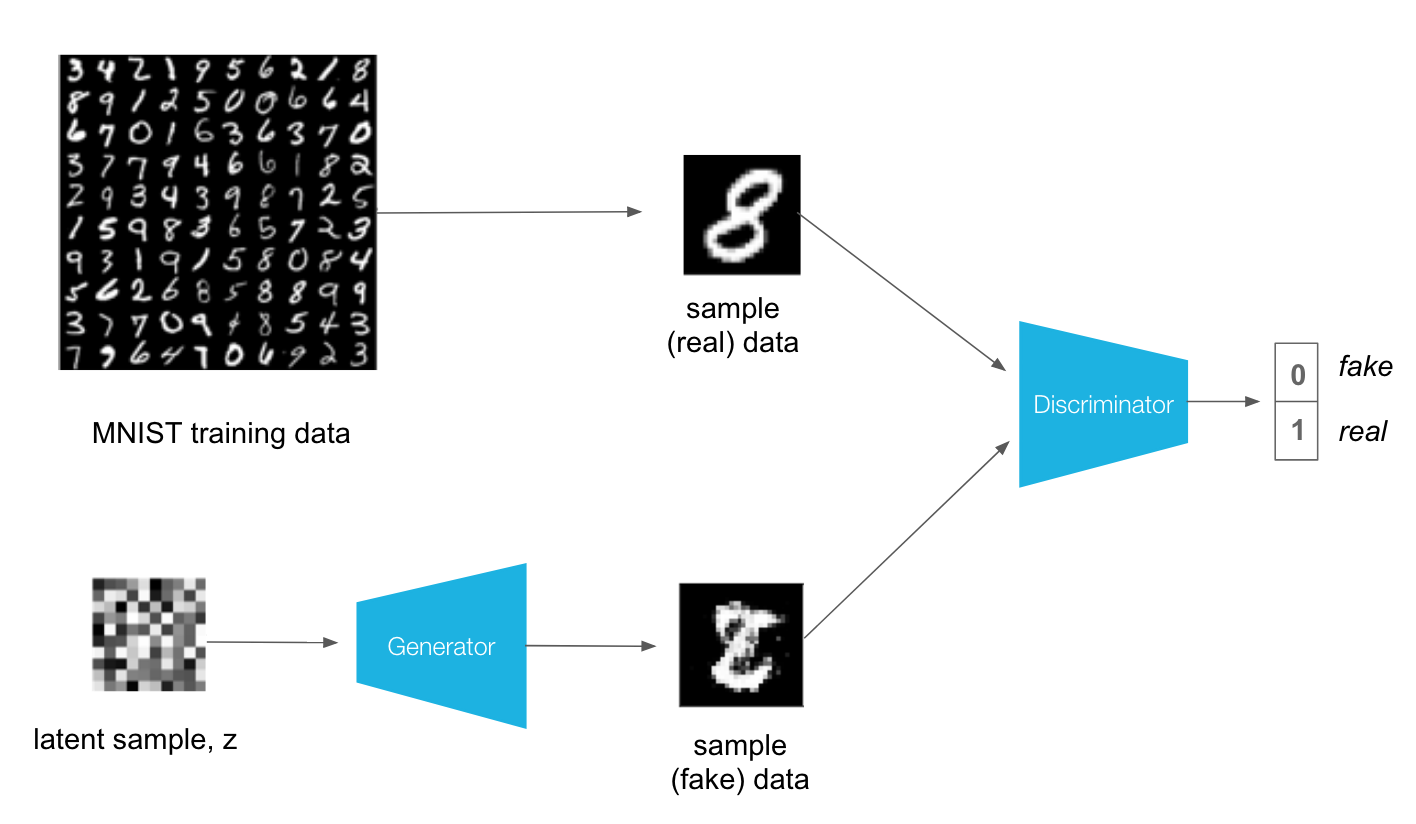

In [1]:
from IPython.display import Image
Image(open('assets/gan_pipeline.png','rb').read())

A estrutura geral de uma GAN é mostrada no diagrama acima, que usa imagem do dataset MNIST como dados. $z$ é um vetor aleatório que a generator usa para construir suas imagens fake. Ele é geralmente chamado **latent vector** e o espaço vetorial é chamado **latent space**. Conforme a generator treina, ela tenta descobrir como mapear vetores latentes para imagens reconhecíveis que são capazes de enganar a discriminator. 

Se você está interessado apenas em gerar novas imagens, você pode descartar a discriminator depois do treino. Neste notebook, vou mostrar como definir e treinar uma GAN em PyTorch e gerar novas imagens. 

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 48989024.34it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1929373.16it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13925950.07it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2938989.32it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Visualizando os dados

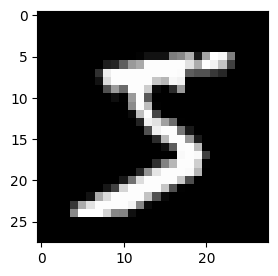

In [3]:
# obtém um batch de imagens de treino
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# pega uma imagem do batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
# Definindo o Modelo

Uma GAN é composta de redes adversariais, uma discriminator e outra generator.

## Discriminator

A rede discriminator será um típico classificador. Para tornar essa rede uma função aproximadora universal, precisaremos de pelo menos uma camada oculta, que deverá ter um atributo chave:

> Todas as camadas ocultas possuem uma função de ativação [Leaky ReLu](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) aplicada aos outputs.

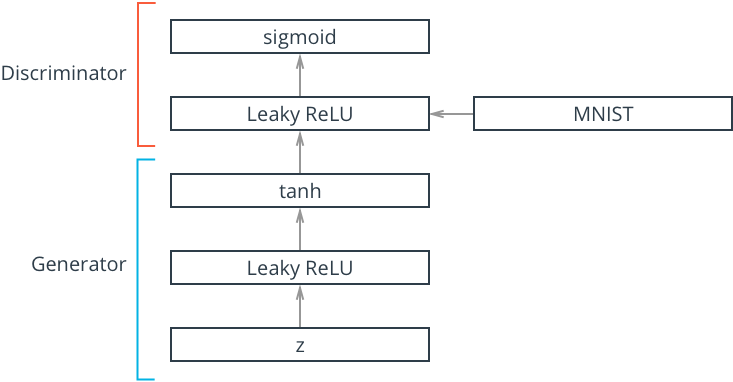

In [2]:
from IPython.display import Image
Image(open('assets/gan_network.png','rb').read())

#### Leaky ReLu

Devemos usar leaky ReLU para permitir que os gradientes fluam sem impedimentos no backpropagation. A leaky ReLU é como uma ReLU normal, exceto que há um pequeno output diferente de zero para valores de inputs negativos. 

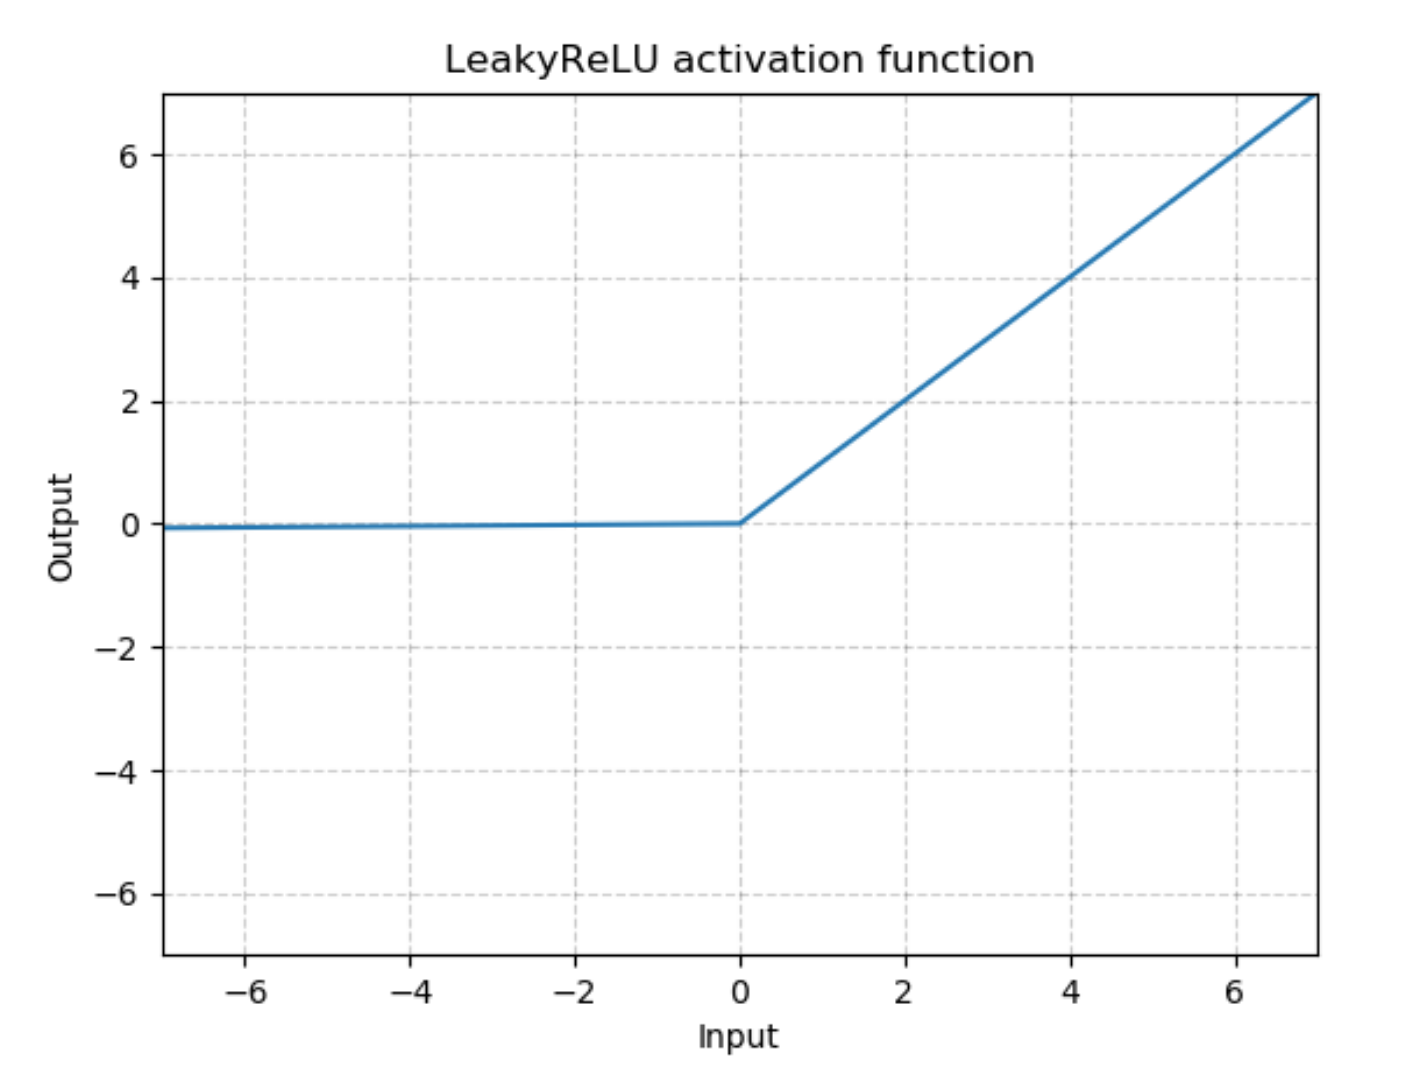

In [3]:
from IPython.display import Image
Image(open('assets/leaky_relu.png','rb').read())

#### Sigmoid Output

Também adotaremos a abordagem de usar uma loss function numericamente mais estável nas saídas. Lembre-se que queremos que a discriminator produza como output um valor 0-1, indicando se a imagem é _real ou fake_. 

> Vamos usar [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), que combina uma função de ativação `sigmoid`**e** entropia cruzada binária numa única função.

Assim, nossa camada final não deve possuir uma função de ativação. 

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()

        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)

        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)

        # dropout layer
        self.dropout = nn.Dropout(0.3)


    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out


## Generator

A rede generator será quase a mesma que a rede discriminator, com exceção que aplicaremos a função de ativação [tangente hiperbólica - tanh](https://pytorch.org/docs/stable/nn.html#tanh) em nossa camada oculta. 


#### tanh Output

É sabido que a generator performa melhor com $tanh$ para o output, visto que escala o output entre -1 e 1. 

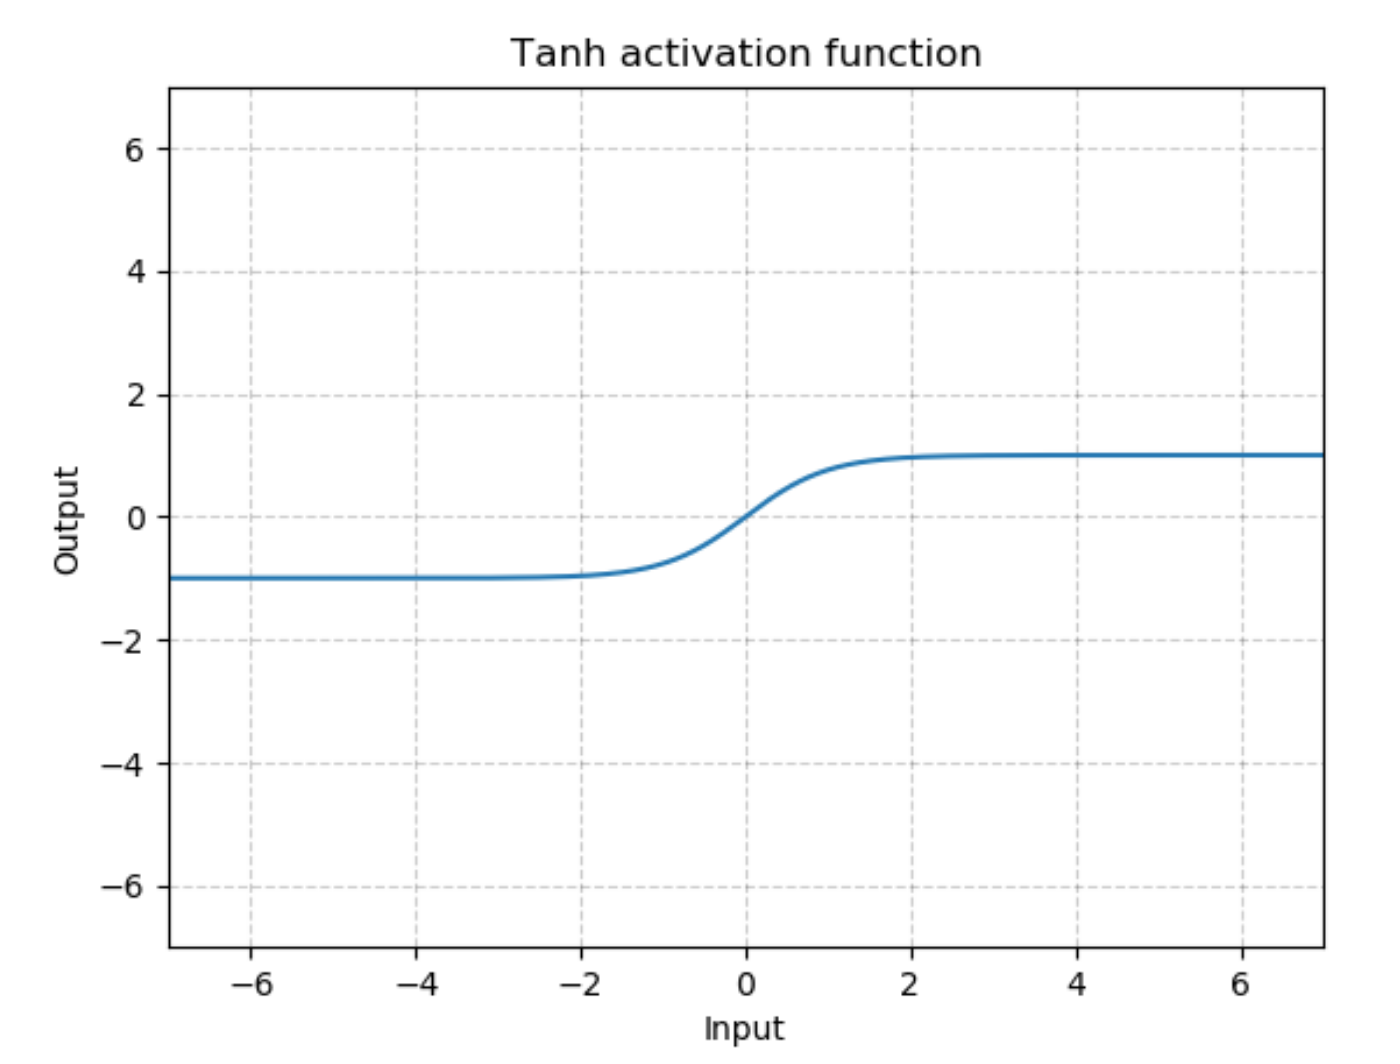

In [4]:
from IPython.display import Image
Image(open('assets/tanh_fn.png','rb').read())

Lembre-se que também queremos que os ouputs sejam comparáveis com os pixels de input *reais*, que são lidos e normalizados para valores entre 0 e 1. 

> Então, também teremos que **escalar nossas imagens de inputs reais para terem um valor de pixel entre -1 e 1** quando treinar a discriminator. 

Faremos isso no processo de treino. 

In [5]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()

        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)

        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out

## Hiperparâmetros do Modelo

In [6]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

## Construindo a Rede completa

Agora instanciamos a discriminator e a generator a partir das classes definidas acima. 

In [7]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


---
## Loss da Discriminator e Generator 

Agora precisamos calcular as loss

### Discriminator Losses

> * Para a discriminator, a loss total é a soma das loss para imagens reais e fake: `d_loss = d_real_loss + d_fake_loss`

* Lembre-se que queremos que a discriminator produza 1 para imagens reais e 0 para imagens fake, então precisamos configurar a loss para refletir isso.

In [ ]:
from IPython.display import Image
Image(open('assets/gan_pipeline.png','rb').read())

As loss serão, como mostradas acima, BCEWithLogitsLoss.

Para imagens reais, queremos `D(real_imagens)=1`, isto é, queremos que a discriminator classifique a imagem real com label = 1, indicando que são reais. Para ajudar a discriminatore generalizar melhor, as labels são **reduzidas de 1.0 para 0.9**. Para isso, usaremos o parâmetro `smooth`; Se True, aplicamos smooth às labels. No PyTorch, é algo parecido com `labels = torch.ones(size) * 0.9`

A loss da discriminator para dados fake é similar. Queremos `D(fake_images) = 0`, em que as imagens fake são as saídas da generator, `fake_images = G(z)`.


### Generator Loss

A loss da generator será semelhante, mas com os rótulos trocados. O objetivo da generator é obter `D(fake_images) = 1`. Neste coso, os rótulos são **trocados** para representar que a generator está tentando enganar a discriminator. 


In [8]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # A ideia é evitar números muito grandes ou zero
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1

    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

Queremos atualizar as variáveis da generator e discriminator separadamente. Assim, definiremos dois otimizadores de maneira separada. 

In [9]:
import torch.optim as optim

# Optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

---
## Training

O treinamento envolverá a alternância entre o treinamento da discriminator e da generator. Usaremos nossas funções `real_loss` e `fake_loss` para nos ajudar a calcular as loss do discriminator em todos os casos a seguir.

### Treinamento da discriminator
1. Calcule a loss da discriminator em imagens reais de treinamento
2. Gere imagens falsas
3. Calcule a loss da discriminator em imagens geradas falsas
4. Some as loss reais e falsas
5. Execute backpropagation + uma etapa de otimização para atualizar os pesos da discriminator

### Treinamento da generator
1. Gere imagens falsas
2. Calcule a loss da discriminator em imagens falsas, usando rótulos **invertidos**!
3. Execute backpropagation + uma etapa de otimização para atualizar os pesos da generator

#### Salvando amostras

À medida que treinamos, também imprimiremos algumas estatísticas de perdas e salvaremos algumas amostras "falsas" geradas.

In [10]:
import pickle as pkl

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):

    for batch_i, (real_images, _) in enumerate(train_loader):

        batch_size = real_images.size(0)

        ## Important rescaling step ##
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)

        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================

        d_optimizer.zero_grad()

        # 1. Train with real images

        # Compute the discriminator losses on real images
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)

        # 2. Train with fake images

        # Generate fake images
        # gradients don't have to flow during this step
        with torch.no_grad():
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)

        # Compute the discriminator losses on fake images
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)

        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()

        # 1. Train with fake images and flipped labels

        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        # Compute the discriminator losses on fake images
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels

        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))


    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))

    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  100] | d_loss: 1.3696 | g_loss: 0.7308
Epoch [    1/  100] | d_loss: 0.6601 | g_loss: 5.1039
Epoch [    1/  100] | d_loss: 1.3713 | g_loss: 1.0318
Epoch [    2/  100] | d_loss: 0.9991 | g_loss: 1.6750
Epoch [    2/  100] | d_loss: 1.2127 | g_loss: 1.7616
Epoch [    2/  100] | d_loss: 0.8641 | g_loss: 1.5447
Epoch [    3/  100] | d_loss: 1.1903 | g_loss: 1.1875
Epoch [    3/  100] | d_loss: 0.9786 | g_loss: 1.5159
Epoch [    3/  100] | d_loss: 0.8388 | g_loss: 3.3212
Epoch [    4/  100] | d_loss: 1.1484 | g_loss: 1.0578
Epoch [    4/  100] | d_loss: 1.0786 | g_loss: 1.4533
Epoch [    4/  100] | d_loss: 1.2190 | g_loss: 1.2440
Epoch [    5/  100] | d_loss: 1.3557 | g_loss: 2.1121
Epoch [    5/  100] | d_loss: 1.3949 | g_loss: 1.1419
Epoch [    5/  100] | d_loss: 1.1378 | g_loss: 1.4520
Epoch [    6/  100] | d_loss: 1.2601 | g_loss: 1.1364
Epoch [    6/  100] | d_loss: 1.2331 | g_loss: 1.1808
Epoch [    6/  100] | d_loss: 1.1015 | g_loss: 1.4686
Epoch [    7/  100] | d_loss

## Training loss

Vamos plotar as loss para generator e discriminator

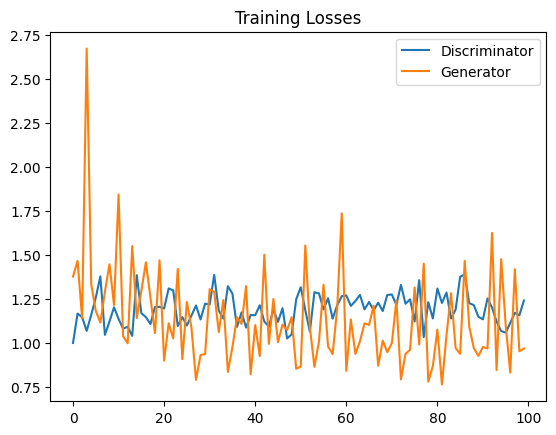

In [11]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Amostras da Generator

Agora podemos ver amostras de imagens do generator. Primeiro, vamos olhar imagens que salvamos durante o processo de treino.

In [12]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [13]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

Essas são amostras da última época de treino. Podemos ver que a generator é capaz do reproduzir números como 1, 7, 3, 2. Entretanto, como é apenas um exemplo, não é representativo de todo o range de imagens que a generator pode produzir. 

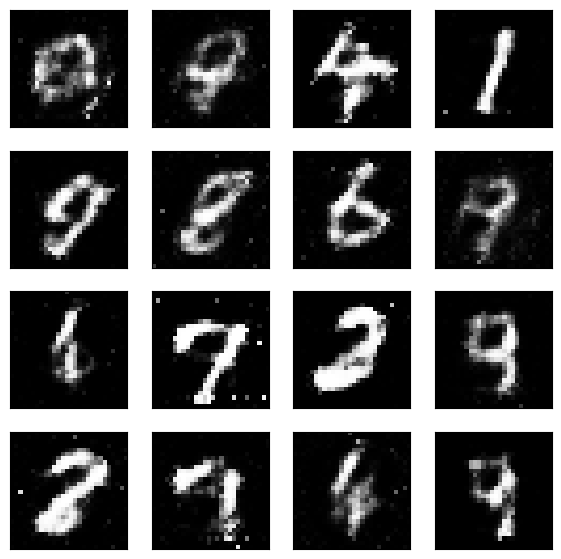

In [14]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Abaixo, são mostradas imagens gerados conforme a rede vai treinando, a cada 10 épocas. 

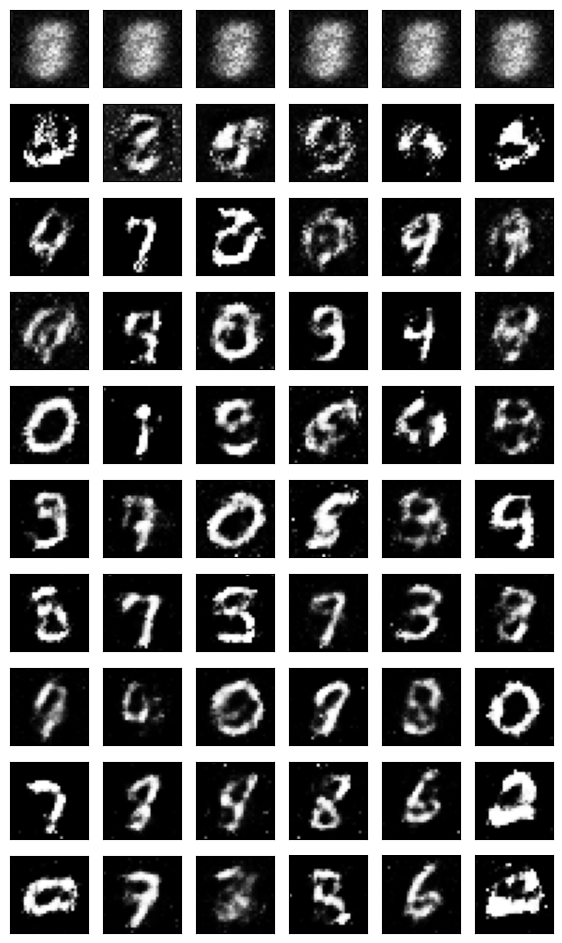

In [15]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

Tudo começa como ruído. Então a rede aprende a produzir apenas a parte central branca e todo o resto preto. Podemos começar a ver algumas estruturas de números emergindo do ruído após algum tempo. 

## Amostrando da generator

Podemos também obter imagens completamente novas da generator usando o modelo salvo depois do treino. **Precisamos apenas passar um novo vetor latente $z$ e obter novas amostras**.

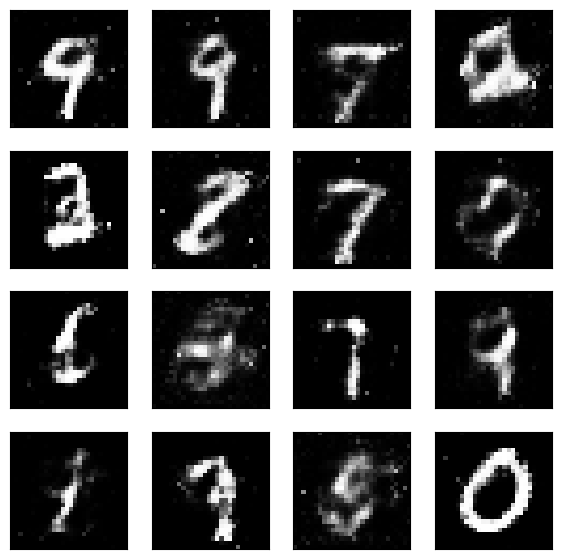

In [16]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])